In [1]:
import pandas as pd

# Load the dataset
file_path = 'C:/Users/amit_/Downloads/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition/ObesityDataSet_raw_and_data_sinthetic.csv'
data = pd.read_csv(file_path)

# Display basic information about the dataset
data.info(), data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

(None,
    Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
 0  Female  21.0    1.62    64.0                            yes   no   2.0   
 1  Female  21.0    1.52    56.0                            yes   no   3.0   
 2    Male  23.0    1.80    77.0                            yes   no   2.0   
 3    Male  27.0    1.80    87.0                             no   no   3.0   
 4    Male  22.0    1.78    89.8                             no   no   2.0   
 
    NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
 0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
 1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
 2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
 3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
 4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   
 
                   MTRANS           NObeyesdad  
 0  Public_Transportation        Normal_Weight  
 1  Public_Transportation        Normal_Weight  
 2  Publ

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical columns
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Display the preprocessed data
data.head(), scaled_data[:5]


(   Gender   Age  Height  Weight  family_history_with_overweight  FAVC  FCVC  \
 0       0  21.0    1.62    64.0                               1     0   2.0   
 1       0  21.0    1.52    56.0                               1     0   3.0   
 2       1  23.0    1.80    77.0                               1     0   2.0   
 3       1  27.0    1.80    87.0                               0     0   3.0   
 4       1  22.0    1.78    89.8                               0     0   2.0   
 
    NCP  CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  MTRANS  NObeyesdad  
 0  3.0     2      0   2.0    0  0.0  1.0     3       3           1  
 1  3.0     2      1   3.0    1  3.0  0.0     2       3           1  
 2  3.0     2      0   2.0    0  2.0  1.0     1       3           1  
 3  3.0     2      0   2.0    0  2.0  0.0     1       4           5  
 4  1.0     2      0   2.0    0  0.0  0.0     2       3           6  ,
 array([[-1.01191369, -0.52212439, -0.87558934, -0.86255819,  0.47229133,
         -2.75976929, -

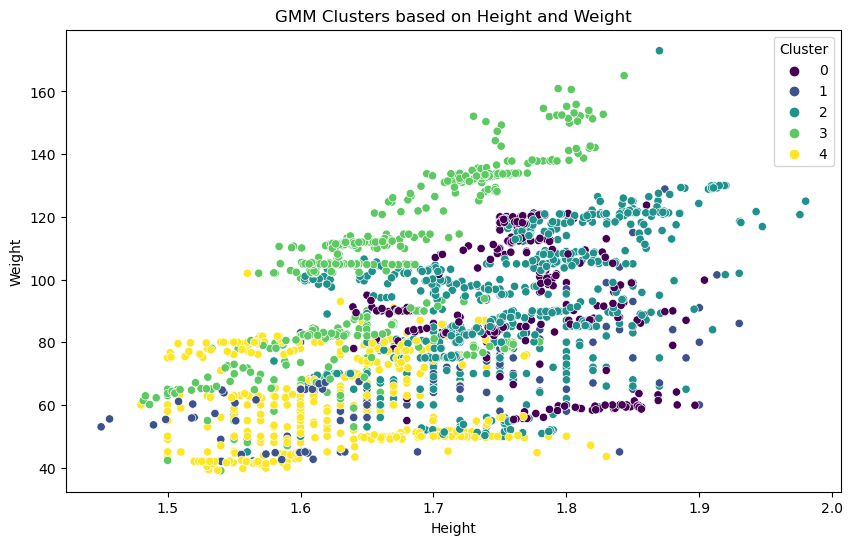

In [3]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=5, random_state=0)
gmm_labels = gmm.fit_predict(scaled_data)

# Add GMM cluster labels to the original data
data['GMM_Cluster'] = gmm_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Height'], y=data['Weight'], hue=data['GMM_Cluster'], palette='viridis')
plt.title('GMM Clusters based on Height and Weight')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend(title='Cluster')
plt.show()


In [10]:
import numpy as np
from scipy.optimize import linear_sum_assignment

#the original labels to integers for comparison
true_labels = data['NObeyesdad']

# Verify unique labels
print(f"Unique true labels: {np.unique(true_labels)}")
print(f"Unique GMM labels: {np.unique(gmm_labels)}")

# Create a cost matrix where cost[i, j] is the number of samples from true label i assigned to cluster j
cost_matrix = np.zeros((len(np.unique(true_labels)), gmm.n_components))
for i in range(len(np.unique(true_labels))):
    for j in range(gmm.n_components):
        cost_matrix[i, j] = np.sum((true_labels == i) & (gmm_labels == j))

# Find the optimal assignment using the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)

# Map the GMM labels to the true labels based on the optimal assignment
mapped_labels = np.zeros_like(gmm_labels)
for i, j in zip(row_ind, col_ind):
    mapped_labels[gmm_labels == j] = i

# Calculate the accuracy
accuracy = accuracy_score(true_labels, mapped_labels)
print(f"GMM Clustering Accuracy: {accuracy}")

Unique true labels: [0 1 2 3 4 5 6]
Unique GMM labels: [0 1 2 3 4]
GMM Clustering Accuracy: 0.3685457129322596


In [9]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Separate features and target
features = data.drop(columns=['NObeyesdad'])
target = data['NObeyesdad']

# Encode categorical variables
categorical_columns = features.select_dtypes(include=['object']).columns
for column in categorical_columns:
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column])

# Standardize numerical features
numerical_columns = features.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

# Dimensionality reduction with PCA
pca = PCA(n_components=10)
features_pca = pca.fit_transform(features)

# Try different number of components for GMM
best_ari = 0
best_nmi = 0
best_silhouette = -1
best_gmm = None

for n_components in range(2, 11):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    clusters = gmm.fit_predict(features_pca)
    
    # Calculate evaluation metrics
    ari = adjusted_rand_score(target, clusters)
    nmi = normalized_mutual_info_score(target, clusters)
    silhouette_avg = silhouette_score(features_pca, clusters)
    
    # Track the best model
    if ari > best_ari:
        best_ari = ari
        best_nmi = nmi
        best_silhouette = silhouette_avg
        best_gmm = gmm

print(f'Best Adjusted Rand Index (ARI): {best_ari}')
print(f'Best Normalized Mutual Information (NMI): {best_nmi}')
print(f'Best Silhouette Score: {best_silhouette}')

# If GMM does not improve, try KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_kmeans = kmeans.fit_predict(features_pca)

# Calculate evaluation metrics for KMeans
ari_kmeans = adjusted_rand_score(target, clusters_kmeans)
nmi_kmeans = normalized_mutual_info_score(target, clusters_kmeans)
silhouette_avg_kmeans = silhouette_score(features_pca, clusters_kmeans)

print(f'KMeans Adjusted Rand Index (ARI): {ari_kmeans}')
print(f'KMeans Normalized Mutual Information (NMI): {nmi_kmeans}')
print(f'KMeans Silhouette Score: {silhouette_avg_kmeans}')

# Choose the best model
if ari_kmeans > best_ari:
    print("KMeans performed better than GMM")
    best_ari = ari_kmeans
    best_nmi = nmi_kmeans
    best_silhouette = silhouette_avg_kmeans

print(f'Final Best Adjusted Rand Index (ARI): {best_ari}')
print(f'Final Best Normalized Mutual Information (NMI): {best_nmi}')
print(f'Final Best Silhouette Score: {best_silhouette}')


Best Adjusted Rand Index (ARI): 0.26363146063438225
Best Normalized Mutual Information (NMI): 0.3459233024596682
Best Silhouette Score: 0.14485844989772076


C:\Users\amit_\.conda\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans Adjusted Rand Index (ARI): 0.1832351363835634
KMeans Normalized Mutual Information (NMI): 0.2633587568129701
KMeans Silhouette Score: 0.18982776658303369
Final Best Adjusted Rand Index (ARI): 0.26363146063438225
Final Best Normalized Mutual Information (NMI): 0.3459233024596682
Final Best Silhouette Score: 0.14485844989772076


In [12]:

# Extract features and labels
features = data.drop(columns=['NObeyesdad'])
labels = data['NObeyesdad']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)
pca_features = pca.fit_transform(scaled_features)

# Apply Gaussian Mixture Model with parameter tuning
best_accuracy = 0
best_gmm = None

for n_components in range(2, 11):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm_labels = gmm.fit_predict(pca_features)

    # Create a cost matrix where cost[i, j] is the number of samples from true label i assigned to cluster j
    cost_matrix = np.zeros((len(np.unique(labels)), n_components))
    for i in range(len(np.unique(labels))):
        for j in range(n_components):
            cost_matrix[i, j] = np.sum((labels == i) & (gmm_labels == j))

    # Find the optimal assignment using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)

    # Map the GMM labels to the true labels based on the optimal assignment
    mapped_labels = np.zeros_like(gmm_labels)
    for i, j in zip(row_ind, col_ind):
        mapped_labels[gmm_labels == j] = i

    # Calculate the accuracy
    accuracy = accuracy_score(labels, mapped_labels)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_gmm = gmm

# Print the best accuracy
print(f"Best GMM Clustering Accuracy: {best_accuracy}")


Best GMM Clustering Accuracy: 0.45665561345333966


In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV

# Add polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
features_poly = poly.fit_transform(features)

# Dimensionality reduction with PCA
pca = PCA(n_components=10)
features_pca = pca.fit_transform(features_poly)

# Try different number of components for GMM with GridSearchCV
param_grid = {'n_components': np.arange(2, 11)}
gmm = GaussianMixture(random_state=42)
gmm_grid = GridSearchCV(gmm, param_grid, cv=5, scoring='adjusted_rand_score')
gmm_grid.fit(features_pca)
best_gmm = gmm_grid.best_estimator_

# Get the best GMM clusters
clusters_gmm = best_gmm.predict(features_pca)

# Calculate evaluation metrics for the best GMM
ari_gmm = adjusted_rand_score(target, clusters_gmm)
nmi_gmm = normalized_mutual_info_score(target, clusters_gmm)
silhouette_avg_gmm = silhouette_score(features_pca, clusters_gmm)

print(f'Best GMM Adjusted Rand Index (ARI): {ari_gmm}')
print(f'Best GMM Normalized Mutual Information (NMI): {nmi_gmm}')
print(f'Best GMM Silhouette Score: {silhouette_avg_gmm}')

# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=5)
clusters_agg = agg_clustering.fit_predict(features_pca)

# Calculate evaluation metrics for Agglomerative Clustering
ari_agg = adjusted_rand_score(target, clusters_agg)
nmi_agg = normalized_mutual_info_score(target, clusters_agg)
silhouette_avg_agg = silhouette_score(features_pca, clusters_agg)

print(f'Agglomerative Clustering Adjusted Rand Index (ARI): {ari_agg}')
print(f'Agglomerative Clustering Normalized Mutual Information (NMI): {nmi_agg}')
print(f'Agglomerative Clustering Silhouette Score: {silhouette_avg_agg}')

# Choose the best model
best_ari = max(ari_gmm, ari_agg)
best_nmi = max(nmi_gmm, nmi_agg)
best_silhouette = max(silhouette_avg_gmm, silhouette_avg_agg)

print(f'Final Best Adjusted Rand Index (ARI): {best_ari}')
print(f'Final Best Normalized Mutual Information (NMI): {best_nmi}')
print(f'Final Best Silhouette Score: {best_silhouette}')


C:\Users\amit_\.conda\New folder\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\amit_\.conda\New folder\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\amit_\.conda\New folder\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\amit_\.conda\New folder\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeE

Best GMM Adjusted Rand Index (ARI): 0.06847843056364038
Best GMM Normalized Mutual Information (NMI): 0.11358760602928655
Best GMM Silhouette Score: 0.24734872688990428
Agglomerative Clustering Adjusted Rand Index (ARI): 0.2770199227044122
Agglomerative Clustering Normalized Mutual Information (NMI): 0.3952181738837248
Agglomerative Clustering Silhouette Score: 0.3686823912669628
Final Best Adjusted Rand Index (ARI): 0.2770199227044122
Final Best Normalized Mutual Information (NMI): 0.3952181738837248
Final Best Silhouette Score: 0.3686823912669628
